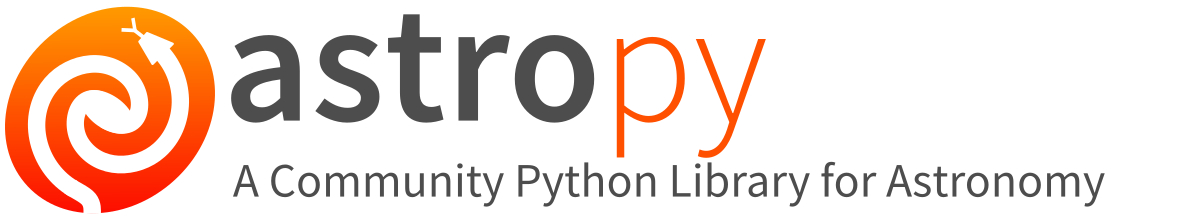

## Sharing code is healthy for the community and the science it produces

- a community developted core library for professional astronomical research
- combines many functionalities from a variety of astronomy packages and languages
- Goals: Usability, Interoperability and Collaboration between packages

### Affiliated Packages

- astronomy related python packages
- adhere to interface standards of astropy but are not (yet) part of the astropy core package
- currently 40 affiliated packages covering many areas of astronomical research

### Since astropy Version 3.0.0 the package only supports Python 3!
### Is now included by default in Anaconda

## Queries, Coordinate Systems, Time and Units
### Observation planning with astropy

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

# Lets observe the star Fomalhaut with the ESO VLT - 8m Telescope in Chile
# Load the position of Fomalhaut from the Simbad database

fomalhaut = SkyCoord.from_name('Fomalhaut')

#print(fomalhaut)

# Load the position of the Observatory
paranal = EarthLocation(lat=-24.62*u.deg, lon=-70.40*u.deg, height=2635*u.m)

#print(paranal)

In [58]:
# We want to observe Fomalhaut next week

midnight = Time('2018-10-15 00:00:00')
delta_midnight = np.linspace(-12, 12, 1000)*u.hour
times_Oct14_to_15 = midnight + delta_midnight
frame_Oct14_to_15 = AltAz(obstime=times_Oct14_to_15, location=paranal)

# Now we transform the Fomalhaut object to the Altitute/Azimuth coordinate system

fomalhaut_altazs_Oct14_to_15 = fomalhaut.transform_to(frame_Oct14_to_15)

#print(fomalhaut_altazs_Oct14_to_15)



In [59]:
from astropy.coordinates import get_sun

sunaltazs_Oct14_to_15 = get_sun(times_Oct14_to_15).transform_to(frame_Oct14_to_15)

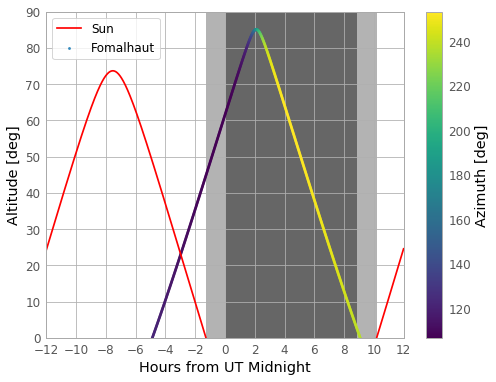

In [60]:
plt.plot(delta_midnight, sunaltazs_Oct14_to_15.alt, color='r', label='Sun')
plt.scatter(delta_midnight, fomalhaut_altazs_Oct14_to_15.alt, 
            c=fomalhaut_altazs_Oct14_to_15.az, label='Fomalhaut', lw=0, s=8,
            cmap='viridis')
plt.fill_between(delta_midnight.to('hr').value, 0, 90,
                 sunaltazs_Oct14_to_15.alt < -0*u.deg, color='0.7', zorder=0)
plt.fill_between(delta_midnight.to('hr').value, 0, 90,
                 sunaltazs_Oct14_to_15.alt < -18*u.deg, color='0.4', zorder=0)
plt.colorbar().set_label('Azimuth [deg]')
plt.legend(loc='upper left')
plt.xlim(-12, 12)
plt.xticks(np.arange(13)*2 -12)
plt.ylim(0, 90)
plt.xlabel('Hours from UT Midnight')
plt.ylabel('Altitude [deg]')
plt.show()

## Fitting models to data

### Simple 1d model

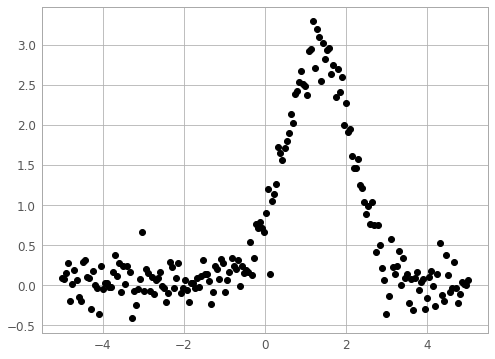

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

# Generate data with some random noise
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)

plt.plot(x, y, 'ko')
plt.show()

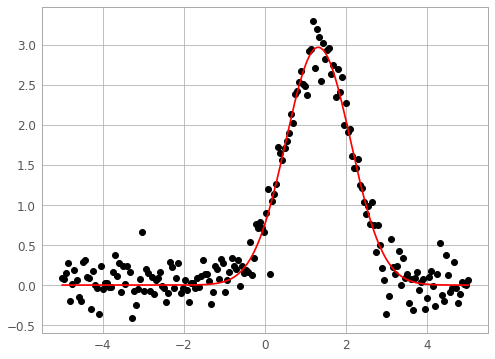

In [62]:
# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

plt.plot(x, y, 'ko')
plt.plot(x, g(x), "r-")
plt.show()

### 2d model

In [63]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

# Generate fake data
np.random.seed(0)
y, x = np.mgrid[:128, :128]
z = 2. * x ** 2 - 0.5 * x ** 2 + 1.5 * x * y - 1.
z += np.random.normal(0., 0.1, z.shape) * 50000.

In [64]:
# Fit the data using astropy.modeling
p_init = models.Polynomial2D(degree=2)
fit_p = fitting.LevMarLSQFitter()

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p = fit_p(p_init, x, y, z)
    


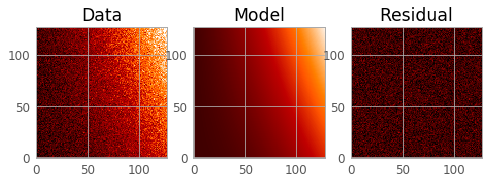

In [65]:
# Plot the data with the best-fit model
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='nearest', vmin=-1e4, vmax=5e4)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), origin='lower', interpolation='nearest', vmin=-1e4,
           vmax=5e4)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(z - p(x, y), origin='lower', interpolation='nearest', vmin=-1e4,
           vmax=5e4)
plt.title("Residual")
plt.show()

## Some affiliated packages

### astroquerry

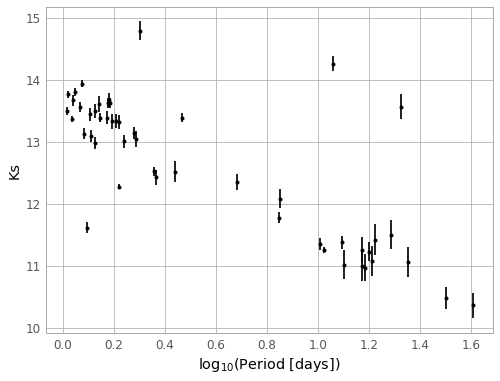

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astroquery.vizier import Vizier

# Cepheids Period-Luminosity data from Bhardwaj et al. 2017
catalog = Vizier.get_catalogs('J/A+A/605/A100')
#print(catalog)

period = np.array(catalog[0]['Period'])
log_period = np.log10(period)
k_mag = np.array(catalog[0]['__Ksmag_'])
k_mag_err = np.array(catalog[0]['e__Ksmag_'])

plt.errorbar(log_period, k_mag, k_mag_err, fmt='k.')
plt.xlabel(r'$\log_{10}$(Period [days])')
plt.ylabel('Ks')
plt.show()

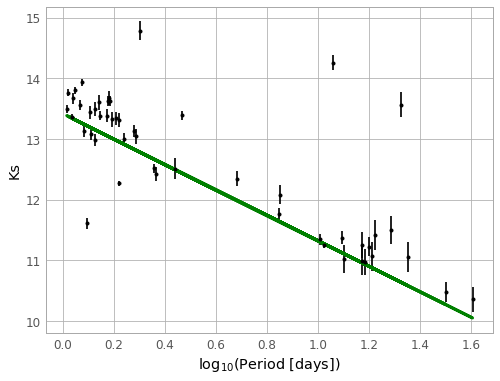

In [67]:
# Lets now fit a simple model to the data
model = models.Linear1D()
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, log_period, k_mag, weights=1.0/k_mag_err**2)

plt.errorbar(log_period,k_mag,k_mag_err,fmt='k.')
plt.plot(log_period, best_fit(log_period), color='g', linewidth=3)
plt.xlabel(r'$\log_{10}$(Period [days])')
plt.ylabel('Ks')
plt.show()

### photutils

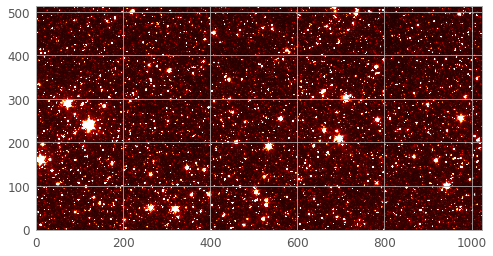

In [68]:
from photutils import datasets
from photutils import aperture_photometry
from photutils import SkyCircularAperture
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.io.fits as fits

hdu = fits.open("./data/spitzer.fits") 
catalog = datasets.load_spitzer_catalog()

plt.imshow(hdu[0].data, vmin=-1, vmax=30, origin="lower", cmap=plt.cm.gist_heat)
plt.show()


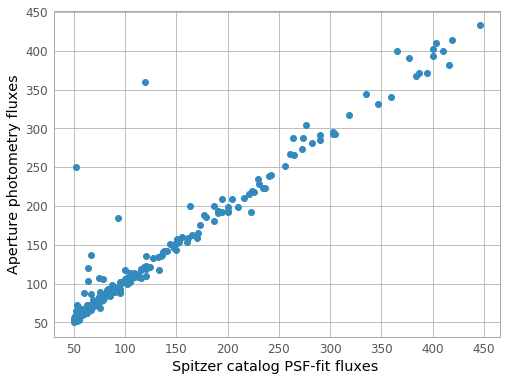

In [69]:
positions = SkyCoord(catalog['l'], catalog['b'], frame='galactic')
apertures = SkyCircularAperture(positions, r=4.8 * u.arcsec) 
phot_table = aperture_photometry(hdu[0], apertures) 

# conversion to flux per pixel with pixel scale of 1.2 arcsec/pixel
factor = (1.2 * u.arcsec) ** 2 / u.pixel   
converted_aperture_sum = (phot_table['aperture_sum'] *
                          factor).to(u.mJy / u.pixel)

# loading the catalog measurements
fluxes_catalog = catalog['f4_5']

import matplotlib.pyplot as plt
plt.scatter(fluxes_catalog, converted_aperture_sum.value)
plt.xlabel('Spitzer catalog PSF-fit fluxes ')
plt.ylabel('Aperture photometry fluxes')
plt.show()

### Fitting circumstellar disks with photutils
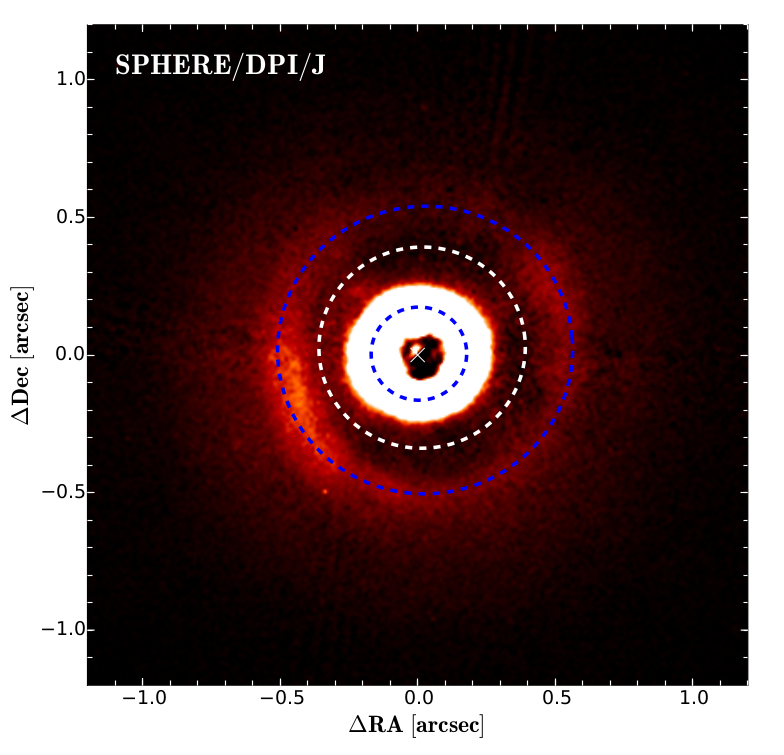

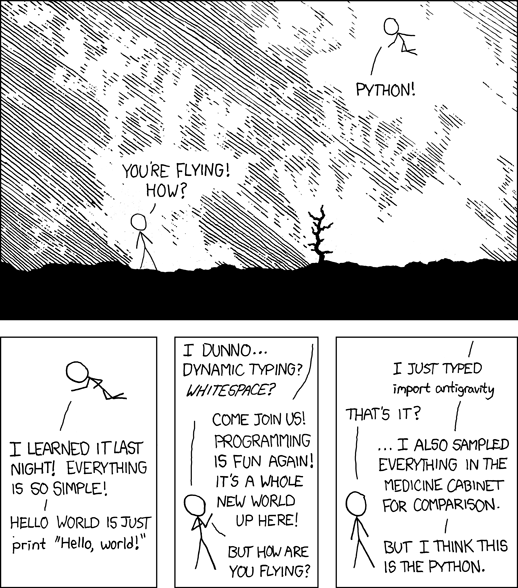
Image Credit: XKCD